In [1]:
import numpy as np 
import pathlib 
import h5py
import os
import datetime 
import pandas as pd
import warnings
import scipy
import pathlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn as sns
# import seaborn_image as isns
sns.set_theme()
sns.set_style("whitegrid")
import os 
import napari
import skimage.measure
import copy
import math
import natsort
import joblib
from joblib import Parallel, delayed

import space
import plotting
import temporal
import utilities
import filehandling
import utilities
import unit_conversion
import contouring
from utilities import multicolour_reshape as reshape 
import signal_analysis
import pickle
from collections.abc import Iterable
# qgrid.enable() 
# import pandasgui
# import tabloo


# %matplotlib widget
# plt.ioff()
# Lazy define some plotting params
chromatic_palette = ['red', 'green', 'blue', 'violet'] # R G B UV
rgbuv_palette = ['red', 'green', 'violet']
chromatic_hues = ["R", "G", "B", "UV"]

achromatic_palette = ['black', 'brown'] # BW BWnoUV 
achromatic_hues = ["BW", "BWnoUV"]
all_palette = chromatic_palette + achromatic_palette
all_hues = ["R", "G", "B", "UV", "BW", "BWnoUV"]
rguv_hues = ["R", "G", "UV"]
nanometers = ["588", "478", "422", "375"]
fish_palette = ["orange", "royalblue","blueviolet", "fuchsia"]

%reload_ext autoreload
%autoreload 2

In [2]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="white", rc=custom_params)
sns.set_context("notebook")
matplotlib.rcParams['svg.fonttype'] = 'none'

In [3]:
pkl_files = filehandling.find_files_in(".pkl", r"C:\Users\Simen\OneDrive\Universitet\PhD\Pickles")

In [4]:
roi_df, rec_df, chroma_df = filehandling.compile_chroma_strf_df(pkl_files, do_bootstrap = True) #, store_objects="D:\Pickles")
# roi_df, rec_df, chroma_df = filehandling.compile_chroma_strf_df(files, do_bootstrap = True, store_objects="D:\Pickles")
# Clearly, IPL_depths nan-ing is borked so you MUST have it otherwise the DFs are not the same size. Not bad, but a bit confusing
#rec_df.to_pickle(r"D:\DataFrames\rec_df.pkl")
#chroma_df.to_pickle(r"D:\DataFrames\chroma_df.pkl")

Current file: C:\Users\Simen\OneDrive\Universitet\PhD\Pickles\2023-11-7_0_0_ColourSWN_200.pkl
Current file: C:\Users\Simen\OneDrive\Universitet\PhD\Pickles\2023-11-7_0_2_ColourSWN_200_1.pkl
Current file: C:\Users\Simen\OneDrive\Universitet\PhD\Pickles\2023-11-7_0_4_ColourSWN_200.pkl
Current file: C:\Users\Simen\OneDrive\Universitet\PhD\Pickles\2023-11-7_MP_0_3_ColourSWN_200_.pkl
Current file: C:\Users\Simen\OneDrive\Universitet\PhD\Pickles\2023-11-8_MP_0_0_ColourSWN_200_.pkl
Current file: C:\Users\Simen\OneDrive\Universitet\PhD\Pickles\2023-6-13_0_0_ColourSWN_200_0.pkl


# Clustering 

In [15]:
from sklearn.cluster import KMeans, OPTICS, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA
# Import the sklearn function
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import clustering

## Kills metadata
def cols_like(list, df):
    final_list = []
    for term in list:
        curr_list = [i for i in df.columns if term in i]
        final_list.extend(curr_list)
    return final_list

def remove_nondata(input_df, to_drop = ['date', 'path', 'filename', 'curr_path', 'strf_keys', 'cell_id', 'size']):
    input_df = input_df.copy()
    actual_drop = [i for i in to_drop if i in input_df.columns]
    input_df = input_df.loc[(input_df!=0).any(axis=1)].drop(actual_drop, axis = 1)
    return input_df

def remove_nonnumeric(input_df, numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']):
    input_df = input_df.copy()
    input_df = input_df.select_dtypes(include=numerics)
    return input_df

def remove_missing_vals(input_df, ignore_cols = ["ipl_depths"], numerical_only = True, return_numerical_only = False):
    # Prevent overwriting 
    input_df = input_df.copy()
    # Numerical or not 
    if numerical_only == True:
        purge_df_numerical = remove_nonnumeric(input_df)
    # say which columns to ignore
    if ignore_cols != None:
        purge_df = purge_df_numerical.drop([i for i in ignore_cols if i in input_df.columns], axis = 1) # the list comprehension
        #just makes sure that if columns are not present the script does not error out:) 
    else:
        purge_df = input_df.copy()
    col = list(purge_df.columns)[:8]
    drop_list = purge_df.index[purge_df[col].eq(0).all(axis=1)].to_list()
    if return_numerical_only == True:
        non_empty_df = purge_df.drop(drop_list, axis = 0)
        # Remember to add back in the ignored columns so we get ones that were numerical
        non_cleaned_input_drop = input_df.drop(drop_list, axis = 0)
        # For each location
        order = list(purge_df.columns)
        for ignored_col, i in zip(ignore_cols, [purge_df_numerical.columns.get_loc(i) for i in ["ipl_depths"]]):
            order.insert(i, ignored_col)
        for fetch_col in order:
            non_empty_df[fetch_col] = non_cleaned_input_drop[fetch_col]
        non_empty_df = non_empty_df[order]
    else:
        non_empty_df = input_df.drop(drop_list, axis = 0)
    return non_empty_df

def prep_input_df(input_df, select_cols = None, scaler = StandardScaler(), nan_replace = 0, remove_missing = True, ignore_scale = None):
    # Can specify columns, otherwise use everything available
    if select_cols == None:
        select_cols = list(input_df.columns)
    # Prevent overwriting 
    input_df = input_df.copy()
    # Drop irrelevant cols (lazy by searching any match, meaning more
    # specific search criteria will yield less data)
    input_df = input_df[cols_like(select_cols, load_df)]
    # Remove missing values (but crucially keep index the same)
    if remove_missing == True: # need a better way of automatiing the below
        input_df = remove_missing_vals(input_df)
    # Kill nans 
    input_df = input_df.fillna(nan_replace)
    # Can scale, otherwise just return the cleaned DF
    if scaler != None:
        # If specified, ignore these columns in the scaling process
        if ignore_scale != None:
            if isinstance(ignore_scale, Iterable) is False:
                raise AttributeError("param 'ignore_scale' must be iterable")
            # Determine which are actually present 
            ignore_scale = [i for i in ignore_scale if i in input_df.columns]
            # Extract temporarily the parts of DF that are to be ignored (for inserting later)
            temp_extract_cols = input_df[ignore_scale].reset_index(drop = True)
            # For user-friendliness lets keep track of the indeces and insert them back in their original order
            ignored_indeces = [input_df.columns.get_loc(c) for c in ignore_scale if c in input_df]
            input_df = input_df.drop(ignore_scale, axis = 1)
        try:
            input_df = pd.DataFrame(scaler.fit_transform(input_df), columns = input_df.columns)
        except TypeError:
            numerics = ['int', 'float', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
            input_df = input_df.select_dtypes(include=numerics)
            input_df = pd.DataFrame(scaler.fit_transform(input_df), columns = input_df.columns)
        if ignore_scale != None: # add ignored cols back in their original order:)
            for column_index, column_name in zip(ignored_indeces, ignore_scale):
                input_df.insert(column_index, column_name, temp_extract_cols[column_name].values)# = temp_extract_cols
    return input_df

def elbow_plot(df, max_it = 50):
    # Assuming df is your DataFrame
    # Specify the range of k values you want to try
    k_values = range(1, max_it)
    # Initialize an empty list to store the sum of squared distances (inertia) for each k
    inertia = []
    # Perform k-means clustering for each k value
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init = "auto")
        kmeans.fit(df)
        inertia.append(kmeans.inertia_)
    # Create an elbow plot using Seaborn
    sns.set(style="whitegrid")
    plt.figure(figsize=(5, 4))
    sns.lineplot(x=k_values, y=inertia, marker='o')
    plt.title('Elbow Plot for K-Means Clustering')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Sum of Squared Distances (Inertia)')
    plt.show()

def df_kmeans(input_df, n_clusters = 15, random_state=0, n_init="auto", apply_cluster_id = True):
    input_df = input_df.copy()
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=n_init)
    kmeans.fit(input_df)
    clusters = kmeans.predict(input_df)
    output_df = pd.DataFrame(input_df, index=input_df.index, columns=input_df.columns)
    output_df["cluster_id"] = clusters
    # output_df["curr_path"] = load_df["curr_path"]
    # if apply_cluster_id == True:
    #     input_df["cluster_id"] = clusters
    return output_df

def df_BayesGMM(input_df, n_components=30, random_state=0, max_iter = 1000, covariance_type="full", apply_cluster_id = True):
    input_df = input_df.copy()
    gm = BayesianGaussianMixture(n_components=n_components, random_state=random_state, 
        max_iter = max_iter, covariance_type=covariance_type).fit(input_df)
    clusters = gm.predict(input_df)
    # output_df["cluster_id"] = clusters
    output_df = pd.DataFrame(input_df, index=input_df.index, columns=input_df.columns)
    output_df["cluster_id"] = clusters
    # if apply_cluster_id == True:
    #     input_df["cluster_id"] = clusters
    return output_df

def df_GMM(input_df, n_components=30, random_state=0, max_iter = 1000, covariance_type="full", apply_cluster_id = True):
    input_df = input_df.copy()
    gm = GaussianMixture(n_components=n_components, random_state=random_state, 
        max_iter = max_iter, covariance_type=covariance_type).fit(input_df)
    clusters = gm.predict(input_df)
    # output_df["cluster_id"] = clusters
    output_df = pd.DataFrame(input_df, index=input_df.index, columns=input_df.columns)
    output_df["cluster_id"] = clusters
    # if apply_cluster_id == True:
    #     input_df["cluster_id"] = clusters
    return output_df    

def df_AggHierarchy(input_df, n_components=30, apply_cluster_id = True):
    input_df = input_df.copy()
    ag_model = AgglomerativeClustering(n_clusters = n_components).fit(input_df)
    input_df["cluster_id"] = ag_model.labels_
    # if apply_cluster_id == True:
    #     input_df["cluster_id"] = clusters
    return input_df    

def apply_clusters(input_df, cluster_id_df, inplace = False):
    if cluster_id_df.shape[0] != input_df.shape[0]:
        raise AttributeError("Index mismatch")
    if "cluster_id" not in list(cluster_id_df.columns):
        raise AttributeError("Column ['cluster_id'] missing from clutser_id_df")
    if inplace == False:
        input_df = input_df.copy()
        input_df["cluster_id"] = cluster_id_df["cluster_id"].values
        return input_df
    else:
        input_df["cluster_id"] = cluster_id_df["cluster_id"].values

def df_pca(input_df, n_comps = "auto", whiten = True):
    if n_comps == "auto":
        n_comps = input_df.shape[-1]
    pca = PCA(n_components=n_comps, whiten = whiten)
    pca.fit(input_df)
    reduced = pca.transform(input_df)
    # print(df_pca(pruned_df).to_numpy() == reduced)
    return pca, pd.DataFrame(reduced, index = input_df.index, columns = [f"PC{i}" for i in range(len(pca.explained_variance_))])

def get_cluster_cols(cluster_id, col_str_list, df):
    search_cols = cols_like(col_str_list, df) + ["cluster_id"]
    df_query = df[search_cols].query(f"cluster_id == {cluster_id}")
    return df_query.drop("cluster_id", axis = 1)

# def plot_df_stats(describe_df, print_stat = False):
#     means =  describe_df.loc["mean"]
#     errors = describe_df.loc["std"]
#     if print_stat == True:
#         print(results)
#     plt.plot(means)   |
#     plt.title("Mean ± STD by paramter")
#     plt.fill_between(range(len(errors)), means - errors, means + errors, alpha = 0.25)
#     plt.axhline(0)

def plot_df_tuning(post_cluster_df, clusters = 0, plot_cols = "all", specify_cluster = None, print_stat = False, ax = None):
    if "cluster_id" not in post_cluster_df.columns:
        raise AttributeError("Please ensure 'cluster_id' columns exists in input DF.")
    if plot_cols == "all":
        # This goes through the DataFrames and identifies which columns are present and extracts them 
        # independent of wavelength (more on parsing that below) 
        unique_cols_sans_wavelength = np.unique([i.split("_")[0] for i in post_cluster_df.columns if i != "cluster_id"])
        check_cols = np.unique([i.split("_")[0] for i in post_cluster_df.columns if i != "cluster_id"])
        if "ipl" in unique_cols_sans_wavelength:
            unique_cols_sans_wavelength = unique_cols_sans_wavelength.astype(object)
            unique_cols_sans_wavelength[np.where(unique_cols_sans_wavelength == "ipl")] = "ipl_depths"
        #assert np.all(check_cols == unique_cols_sans_wavelength)
        num_stats = len(unique_cols_sans_wavelength)
    else:
        raise ImportError("jokes on you")
    if np.all(ax == None):
        fig, ax = plt.subplots(1, num_stats, figsize=np.array([num_stats, .75])*4)
        fig.tight_layout()
        if num_stats == 1:
            ax = [ax]
    if type(clusters) == int:
        clusters = [clusters]
    for n, clust_num in enumerate(clusters):
        for n, (i, param) in enumerate(zip(ax, unique_cols_sans_wavelength)):
            if n == 0:
                i.set_ylabel("Mean ± STD by paramter")
            results = get_cluster_cols(clust_num, unique_cols_sans_wavelength, post_cluster_df).describe()
            wavelength_params = cols_like([param], results)
            means =  results[wavelength_params].loc["mean"]
            errors = results[wavelength_params].loc["std"]
            # 
            if print_stat == True:  
                print(results)
            if param == "ipl_depths":
                sns.histplot(data = post_cluster_df.query(f"cluster_id == {clust_num}"), y = "ipl_depths", binrange = (0, 100), binwidth = 10, ax = i)
                i.set_xlim(0, 20)
            else:
                # plot individuals
                i.plot(post_cluster_df.query(f"cluster_id == {clust_num}")[wavelength_params].T, alpha = 0.1, color = 'k')
                # plot stats
                i.plot(means)
                i.set_xticks(range(len(wavelength_params)), [i.split("_")[-1] for i in wavelength_params])
                i.fill_between(range(len(errors)), means - errors, means + errors, alpha = 0.25)
                # set a lil line at 0 for easier viz
                i.axhline(0, color = "lightgrey", alpha = 1, ls = '--')
            i.set_title(param)

def sum_normalize_data(data):
    """
    scaling values to sum to 1 while preserving their relative proportions
    """
    data_array = np.array(data)
    total = np.sum(data_array)
    normalized_data = data_array / total
    return normalized_data.tolist()

def sum_div_norm(data):
    # Normalize the data so that the sum equals 1
    normalized_data = data / np.sum(data)
    # The sum of normalized values will be 1
    return normalized_data
    
load_df = chroma_df.copy()

### Data exploration 

C:\Users\Simen\AppData\Local\Temp\ipykernel_12040\3282545755.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = load_df.corr()


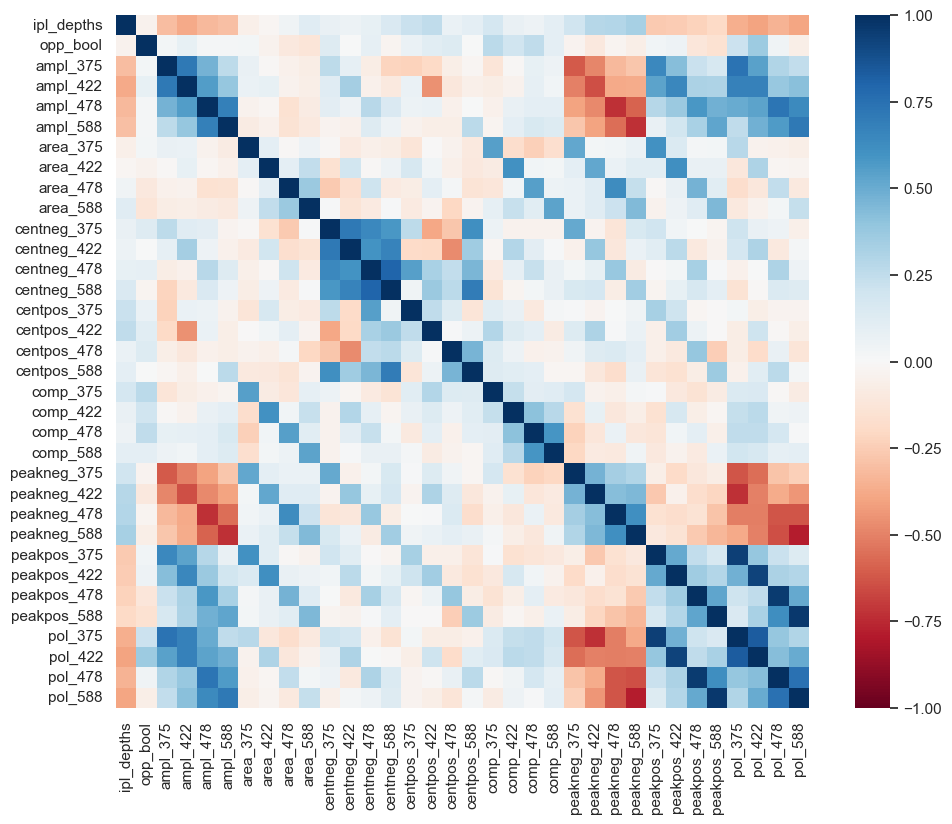

In [6]:
corrmat = load_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax = 1, vmin = -1, square=True, cmap="RdBu");

### Data exploration

[]

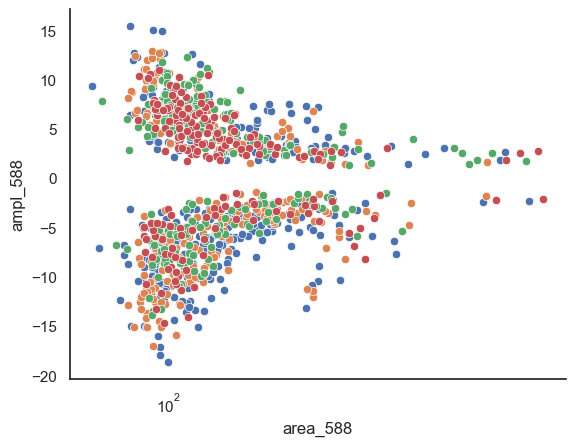

In [7]:
fig, ax = plt.subplots()
for i in ["588", "478", "422", "375"]:
    sns.scatterplot(load_df, x = f"area_{i}", y = f"ampl_{i}", ax= ax)
#ax.set_yscale("log")
ax.semilogx()

## Cluster

## Post-PCA Clustering

In [8]:
# def apply_scaling(scaling_target_list, scaling_function_list, *params_list):
#     for df, sclaing in scaling_target_list, 

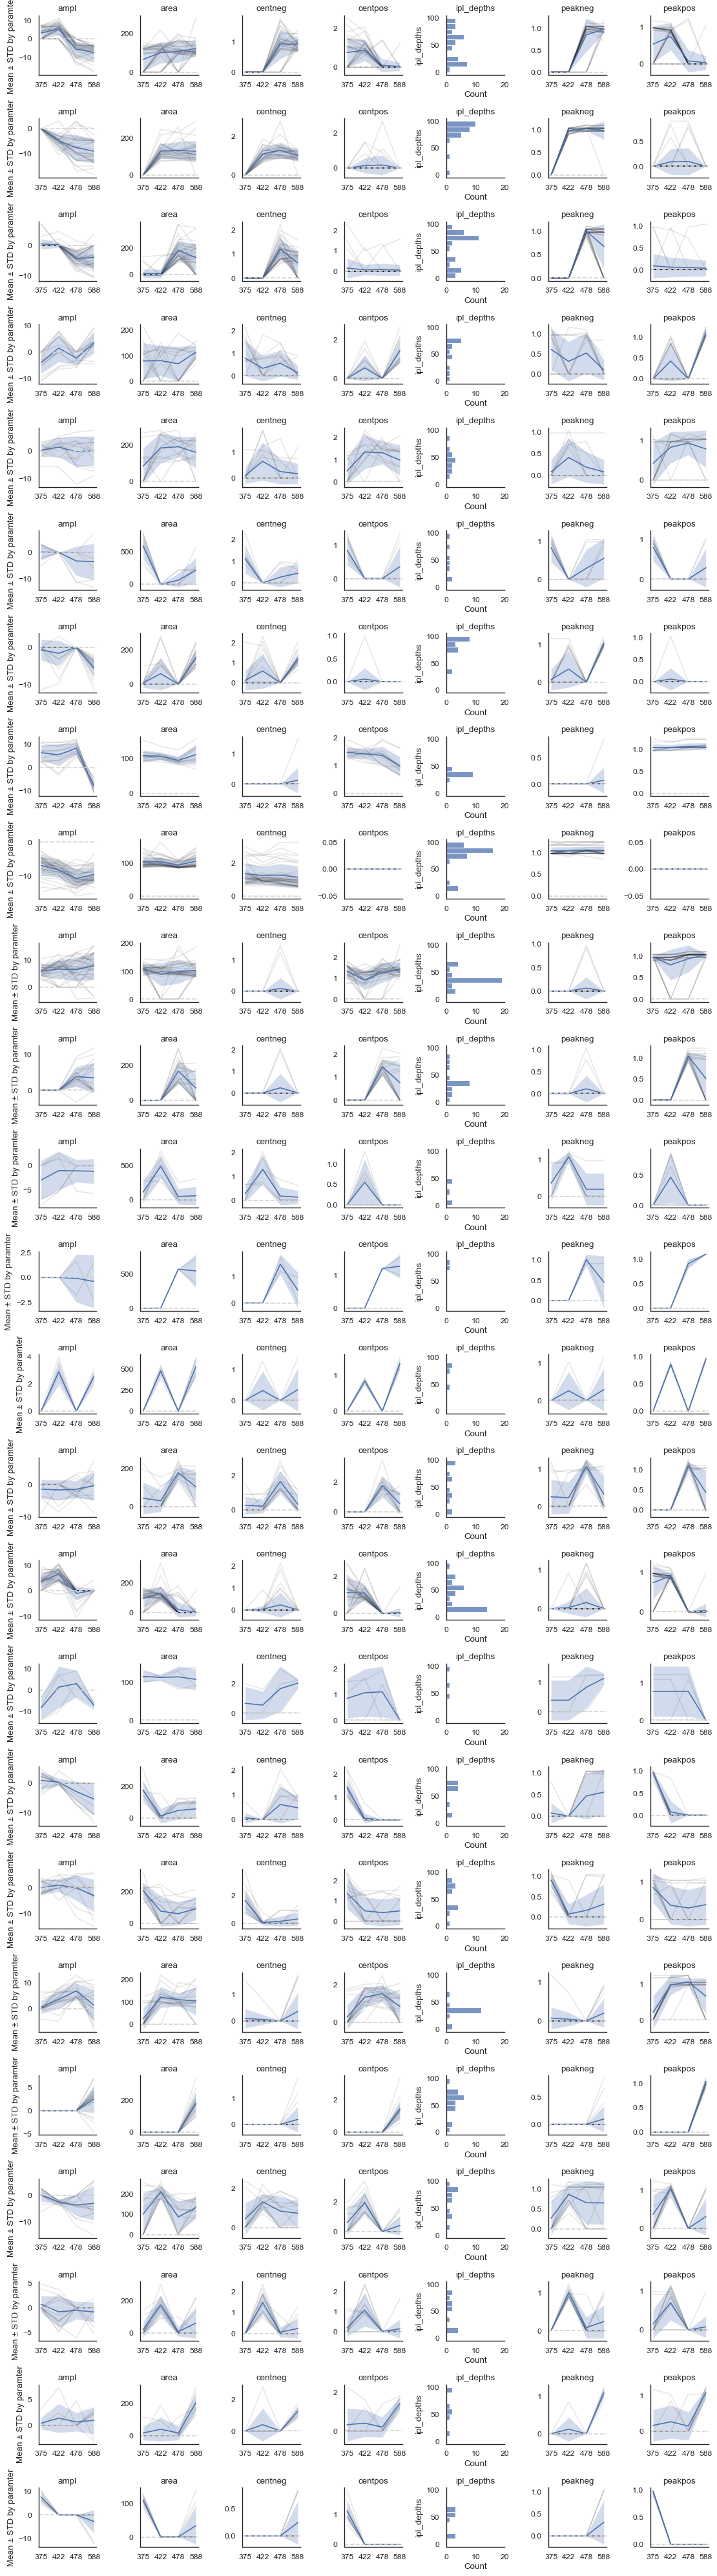

In [18]:
## Prepare data by cleaning and scaling, plus non scaled version of cleaned DF
cluster_params = ["amp", "area", "peak"]
#pruned_df[cols_like(["ampl"], pruned_df)]= sum_div_norm(pruned_df[cols_like(["ampl"], pruned_df)].values)
pruned_df = prep_input_df(load_df, cluster_params, scaler = None)
## Scale amplitude differentally
# pruned_df[cols_like(["amp"], pruned_df)] = sum_normalize_data(pruned_df[cols_like(["amp"], pruned_df)])

# Run PCA
pruned_pca, pruned_df_pca = df_pca(pruned_df, whiten=True)
# Run clustering on PCA result
n_clust = 25
pruned_df_clust = df_AggHierarchy(pruned_df_pca, n_clust)

## Create DF for visualising clustering results 
stats_params =  ["ipl", "amp", "area", "peak", "cent"] 
stats_df = prep_input_df(load_df, stats_params, scaler = None, ignore_scale=cols_like([i for i in stats_params if i not in cluster_params], load_df))
#stats_df[cols_like(["amp"], pruned_df)] = sum_div_norm(stats_df[cols_like(["amp"], pruned_df)])
visualise_clust_df = apply_clusters(stats_df, pruned_df_clust)

# Apply output by writing clusters to input data
df_output = apply_clusters(visualise_clust_df, pruned_df_clust)

# # Vizualize n clusters
num_stats = len(stats_params) + 2
fig, ax = plt.subplots(n_clust, num_stats, figsize = (num_stats*2, n_clust*2), dpi = 80)
fig.tight_layout()
for n, i in enumerate(range(n_clust)):
    plot_df_tuning(visualise_clust_df, i, ax = ax[n, 0:num_stats])
fig.tight_layout()

# plt.show()
# sns.boxplot(output_df, x = "cluster_id", y = "ipl_depths")
# plt.title("Distribution of cell IPL depth by cluster")

# # PCA for visualisation
# clustering.display_factorial_planes(pruned_df_pca.to_numpy(), pruned_pca, [(0,1)], labels = pruned_df_clust["cluster_id"], 
#     illustrative_var = pruned_df_clust["cluster_id"], alpha = 1,  cmap = "rainbow")

# plot_df_tuning(pruned_df_nonscale, pruned_df_bGMM, [0, 1])